In [55]:
'''
Ali Rabiee
99210389
3D_HW5_Solutions
'''

'\nAli Rabiee\n99210389\n3D_HW5_Solutions\n'

In [56]:
#Import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from scipy import ndimage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

In [57]:
#Read Images
planes = cv2.imread("planes.png")
planes_gray = cv2.cvtColor(planes,cv2.COLOR_BGR2GRAY)

# **Problem_1 : Template Matching**

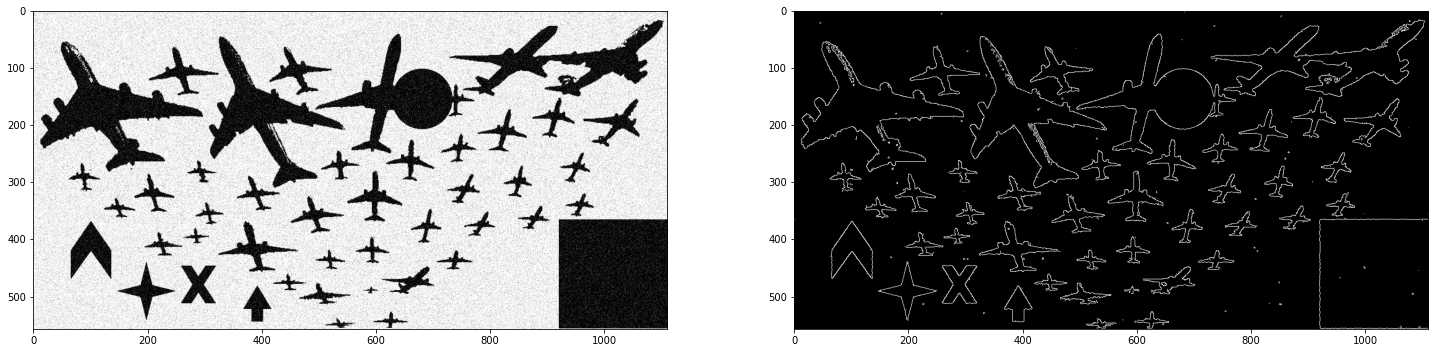

In [58]:
#Part(a)

#Edge Detection Using Canny Edge Detector
def detect_edge(image):
    image_with_edges = cv2.Canny(image , 250, 500)
    images = [image, image_with_edges]
    location = [121, 122]
    fig = plt.gcf()
    fig.set_size_inches(25, 15)
    for loc, img in zip(location, images):
        plt.subplot(loc)
        plt.imshow(img, cmap='gray')
    plt.show()
    
detect_edge(planes)

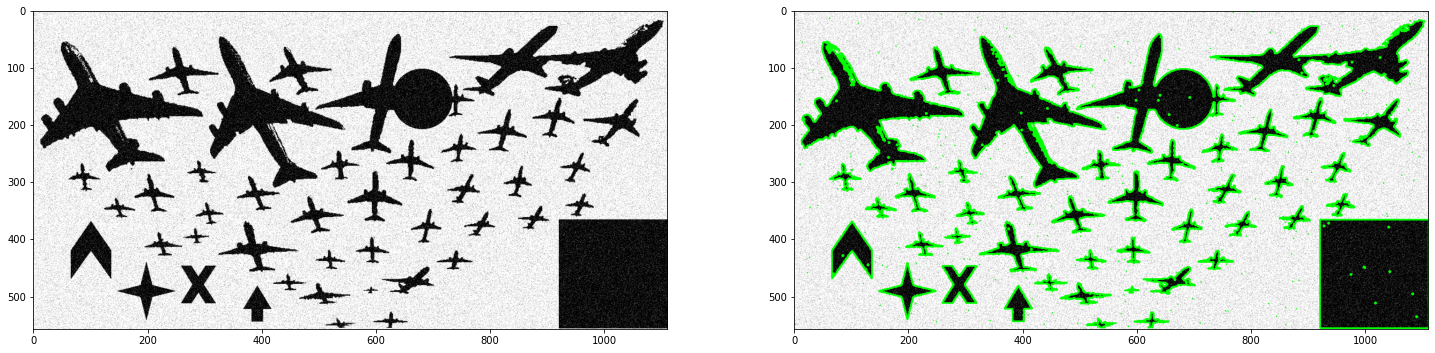

In [59]:
#Contours Detection
def detect_contour(image):
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    images = [image_gray, image_with_contours]
    location = [121, 122]
    fig = plt.gcf()
    fig.set_size_inches(25, 15)
    for loc, img in zip(location, images):
        plt.subplot(loc)
        plt.imshow(img, cmap='gray')
    plt.show()

image = planes.copy()
detect_contour(image)

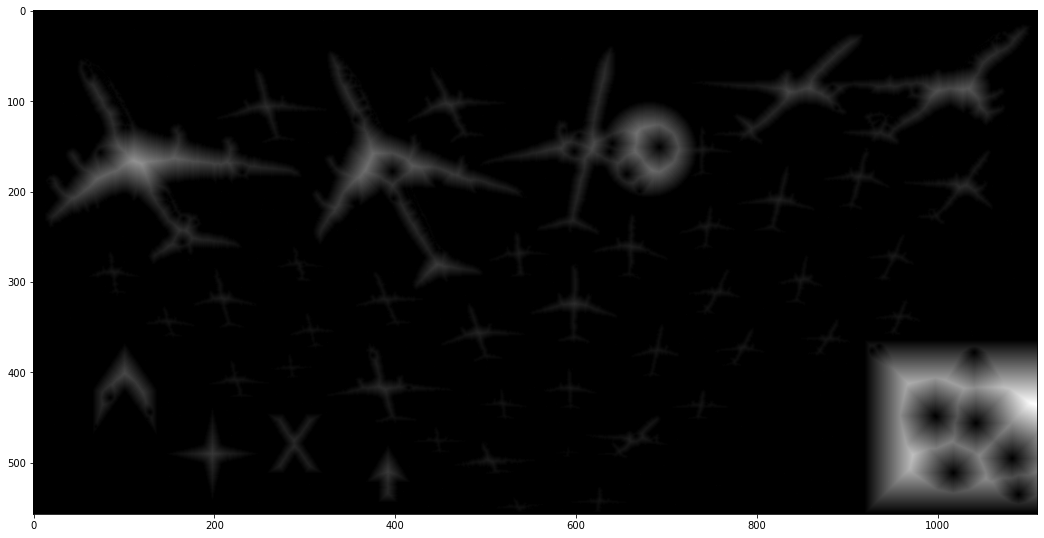

In [60]:
#Part(b)
#Distance Transform

#With OpenCV Library
def Distance_transform(image):
  image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  dist = cv2.distanceTransform(thresh,cv2.DIST_L2, cv2.DIST_MASK_3)
  #Normalized processing, otherwise the effect will not be seen
  cv2.normalize(dist,dist,0,1,cv2.NORM_MINMAX)
  #Showing result 
  fig = plt.gcf()
  fig.set_size_inches(18, 18)
  plt.imshow(dist, cmap='gray')

#Without OpenCV Library
def distance_transform(img):
   w, h = img.shape
   dt = np.zeros((w,h), np.uint32)
   #Forward pass
   x = 0
   y = 0
   if img[x,y] == 0:
      dt[x,y] = 65535 #some large value
   for x in range(1, w):
      if img[x,y] == 0:
         dt[x,y] = 3 + dt[x-1,y]
   for y in range(1, h):
      x = 0
      if img[x,y] == 0:
         dt[x,y] = min(3 + dt[x,y-1], 4 + dt[x+1,y-1])
      for x in range(1, w-1):
         if img[x,y] == 0:
            dt[x,y] = min(4 + dt[x-1,y-1], 3 + dt[x,y-1], 4 + dt[x+1,y-1], 3 + dt[x-1,y])
      x = w-1
      if img[x,y] == 0:
         dt[x,y] = min(4 + dt[x-1,y-1], 3 + dt[x,y-1], 3 + dt[x-1,y])
   #Backward pass
   for x in range(w-2, -1, -1):
      y = h-1
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 3 + dt[x+1,y])
   for y in range(h-2, -1, -1):
      x = w-1
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 3 + dt[x,y+1], 4 + dt[x-1,y+1])
      for x in range(1, w-1):
         if img[x,y] == 0:
            dt[x,y] = min(dt[x,y], 4 + dt[x+1,y+1], 3 + dt[x,y+1], 4 + dt[x-1,y+1], 3 + dt[x+1,y])
      x = 0
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 4 + dt[x+1,y+1], 3 + dt[x,y+1], 3 + dt[x+1,y])
   return dt

Distance_transform(planes) 

In [61]:
#Part(c)

#Compute Chamfer distances
templates = []
chamfer_dist = []
for i in range(18):
  template=cv2.imread(f"template{i+1}.png",0)
  templates.append(template)
  chamfer_dist.append(ndimage.convolve(planes_gray.copy(), template, mode='constant', cval=0.0))

In [62]:
#Part(d)&(e)
#Use threshold for each template & Find matches

#compute NMS
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
 
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
 
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
 
    # return only the bounding boxes that were picked
    return boxes[pick]

In [63]:
#compute iou
def compute_iou(box, boxes, box_area, boxes_area):
    # this is the iou of the box against all other boxes
    assert boxes.shape[0] == boxes_area.shape[0]
    # get all the origin-ys
    # push up all the lower origin-xs, while keeping the higher origin-xs
    ys1 = np.maximum(box[0], boxes[:, 0])
    # get all the origin-xs
    # push right all the lower origin-xs, while keeping higher origin-xs
    xs1 = np.maximum(box[1], boxes[:, 1])
    # get all the target-ys
    # pull down all the higher target-ys, while keeping lower origin-ys
    ys2 = np.minimum(box[2], boxes[:, 2])
    # get all the target-xs
    # pull left all the higher target-xs, while keeping lower target-xs
    xs2 = np.minimum(box[3], boxes[:, 3])
    # each intersection area is calculated by the
    # pulled target-x minus the pushed origin-x
    # multiplying
    # pulled target-y minus the pushed origin-y
    # we ignore areas where the intersection side would be negative
    # this is done by using maxing the side length by 0
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    # each union is then the box area
    # added to each other box area minusing their intersection calculated above
    unions = box_area + boxes_area - intersections
    # element wise division
    # if the intersection is 0, then their ratio is 0
    ious = intersections / unions
    return ious

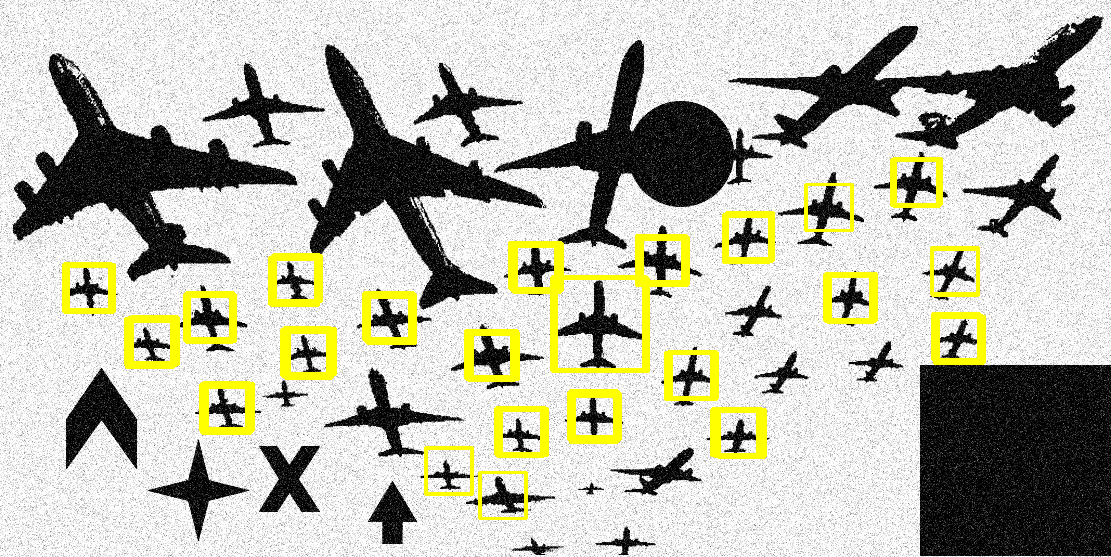

In [64]:
image = planes.copy()

#Specify a threshold
threshold = 0.2719

#Read templates
templates = []
for i in range(18):
  template=cv2.imread(f"template{i+1}.png",0)
  templates.append(template)

#Create a binary thresholded image
_, binary = cv2.threshold(planes_gray, 150, 300, cv2.THRESH_BINARY_INV)

#Store width and heigth of template in w and h
#Perform match operations
for template in templates:
  w, h = template.shape[::-1]
  res = cv2.matchTemplate(binary, template, cv2.TM_CCOEFF_NORMED)
  #Store the coordinates of matched area in a numpy array
  loc = np.where(res >= threshold)
  #Draw a rectangle around the matched region.
  for pt in zip(*loc[::-1]):
    cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)

cv2_imshow(image)


In [65]:
#Part(f)
#Faster method
#We can use this function for non_max_suppression to make our code faster

def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

# **Problem_2 : ICP Algorithm**

In [66]:
#Part(a)

def getTransform(p1, p2): 
    '''
    Takes two cloudpoints p1 , p2  
    Returns rotation and transform metrices 
    that maps corresponding points p1 to p2

    '''
    dim = p1.shape[1]

    #Normalize 
    p1_mean = np.mean(p1, axis=0)
    p2_mean = np.mean(p2, axis=0)
    p1_norm = p1 - p1_mean
    p2_norm = p2 - p2_mean

    #SVD decomposition
    H = np.dot(p1_norm.T, p2_norm)
    U, S, V = np.linalg.svd(H)
    R = np.dot(V.T, U.T)
    if np.linalg.det(R) < 0:
      V[dim-1,:] *= -1
      R = np.dot(V.T, U.T)

    #translation
    t = p2_mean.T - np.dot(R, p1_mean.T)

    #homogeneous transformation
    Trans = np.identity(dim+1)
    Trans[:dim, :dim] = R
    Trans[:dim, dim] = t

    return Trans, R, t

In [67]:
#Implement ICP Algorithm
def icp(a, b, no_iterations = 13):
    '''
    The Iterative Closest Point estimator.
    Takes two cloudpoints a[x,y], b[x,y] and the number of iterations
    Returns the affine transform that transforms the cloudpoint a to the cloudpoint b

    '''
    #make homogeneous points
    dim = a.shape[1]
    src = np.ones((dim + 1, a.shape[0]))
    dst = np.ones((dim + 1, b.shape[0]))
    src[:dim,:] = np.copy(a.T)
    dst[:dim,:] = np.copy(b.T)

    for i in range(no_iterations):
        #Find the nearest neighbors
        n = NearestNeighbors(n_neighbors=1)
        n.fit(dst[:dim,:].T)
        distances, indices = n.kneighbors(src[:dim,:].T, return_distance=True) 
        distances, indices = distances.ravel(), indices.ravel()

        #Compute the transformation
        Trans, R, _ = getTransform(src[:dim,:].T, dst[:dim,indices].T)
        src = np.dot(Trans, src)
        
    Trans, R, t = getTransform(a, src[:dim,:].T)
    
    return Trans, R, t    

In [68]:
#Read files
pc1 = np.load("pc1.npy")
pc2 = np.load("pc2.npy")

In [69]:
#Result
Trans_ICP, R_ICP, t_ICP = icp(pc1,pc2)
print(f"Rotaton Matrix with ICP : \n\n {R_ICP} \n\n")
print(f"Transformation Matrix with ICP : \n\n {Trans_ICP} \n")

Rotaton Matrix with ICP : 

 [[ 0.93027167  0.33705088 -0.14488384]
 [-0.36682602  0.86076202 -0.35288442]
 [ 0.0057705   0.38142554  0.92438156]] 


Transformation Matrix with ICP : 

 [[ 0.93027167  0.33705088 -0.14488384 -2.83847925]
 [-0.36682602  0.86076202 -0.35288442 -1.54294346]
 [ 0.0057705   0.38142554  0.92438156 -1.17713859]
 [ 0.          0.          0.          1.        ]] 



In [70]:
#Part(b)

#Implement PCA Algorithm
def pca(a, b) :
  return getTransform(a, b)

In [71]:
#Result
Trans_PCA, R_PCA, t_PCA = pca(pc1,pc2)
print(f"Rotation Matrix with PCA : \n\n {R_PCA} \n\n")
print(f"Transformation Matrix with PCA : \n\n {Trans_PCA} \n")

Rotation Matrix with PCA : 

 [[-0.5820724  -0.8107543   0.06220377]
 [ 0.37610617 -0.2006177   0.9045975 ]
 [-0.7209272   0.5499365   0.4217037 ]] 


Transformation Matrix with PCA : 

 [[-0.58207238 -0.8107543   0.06220377  3.53955865]
 [ 0.37610617 -0.2006177   0.90459752 -0.2022891 ]
 [-0.72092718  0.54993647  0.4217037  -0.12166542]
 [ 0.          0.          0.          1.        ]] 





---






**Comparing results of PCA & ICP Algorithm with mean_squared_error**  

In [72]:
MSE = mean_squared_error(R_ICP, R_PCA)
print(f'MSE of results = {MSE}')

MSE of results = 0.8573814440625206


**That seems good :)**

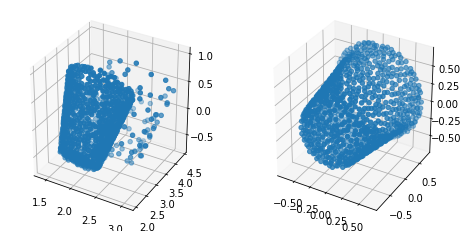

In [82]:
#Visualize pointclouds before transformations

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
xs = pc1.T[0]
ys = pc1.T[1]
zs = pc1.T[2]
ax.scatter(xs, ys, zs)

ax = fig.add_subplot(1, 2, 2, projection='3d')
xs = pc2.T[0]
ys = pc2.T[1]
zs = pc2.T[2]
ax.scatter(xs, ys, zs)

plt.show()

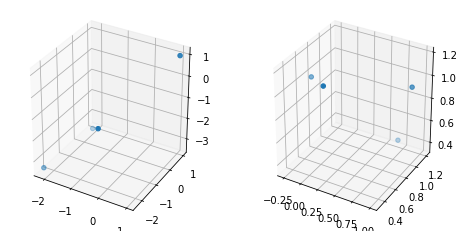

In [85]:
#Visualize pointclouds after ICP transformation
X0 = np.ones((1024,1))
pc11 = np.hstack((pc1,X0))
pc22 = np.hstack((pc2,X0))

pc2_new = Trans_ICP @ pc11.T
pc1_new = Trans_ICP @ pc22.T

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
xs = pc1_new.T[0]
ys = pc1_new.T[1]
zs = pc1_new.T[2]
ax.scatter(xs, ys, zs)

ax = fig.add_subplot(1, 2, 2, projection='3d')
xs = pc2_new.T[0]
ys = pc2_new.T[1]
zs = pc2_new.T[2]
ax.scatter(xs, ys, zs)

plt.show()


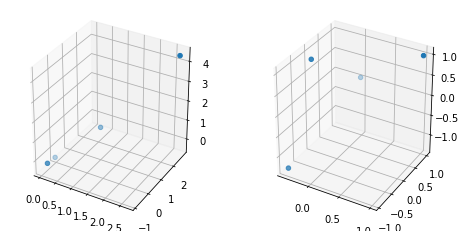

In [86]:
#Visualize pointclouds after PCA transformation
X0 = np.ones((1024,1))
pc11 = np.hstack((pc1,X0))
pc22 = np.hstack((pc2,X0))

pc2_new = Trans_PCA @ pc11.T
pc1_new = Trans_PCA @ pc22.T

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
xs = pc1_new.T[0]
ys = pc1_new.T[1]
zs = pc1_new.T[2]
ax.scatter(xs, ys, zs)

ax = fig.add_subplot(1, 2, 2, projection='3d')
xs = pc2_new.T[0]
ys = pc2_new.T[1]
zs = pc2_new.T[2]
ax.scatter(xs, ys, zs)

plt.show()
